# AB-тестирование
## Задание AB.6


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 1 &mdash; 10 баллов;
* Задача 2 &mdash; 40 баллов;
* Задача 3 &mdash; 70 баллов;
* Задача 4 &mdash; 60 баллов.

----


In [1]:
from enum import Enum
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.stats import multitest
from statsmodels.stats.proportion import proportion_confint
from statsmodels.formula.api import ols

from statsmodels.stats.multitest import multipletests

import scikit_posthocs as sp

from itertools import product

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pof

import seaborn as sns

sns.set(style="darkgrid", font_scale=1, palette="Set2")

# параллельные вычисления
from joblib import Parallel, delayed

import warnings

warnings.filterwarnings("ignore")
# отключает FutureWarning и при параллельном вычислении
import os

os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"

In [2]:
# Bot check

# HW_ID: ds_ab6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status:  final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

---
### Задача 1.

Выберите несколько человек (не менее 5) с DS-потока по состоянию на осенний семестр и сравните их успеваемость методами дисперсионного анализа, рассмотрев оценки по всем заданиям одного типа (ST/SP/ML). Обратите внимание, что в отличии от примера с презентации в данном случае исследуемым фактором является человек, а задание &mdash; мешающий фактор.

Вытащу данные по домашкам за ML

In [3]:
data = {
    "Name": [
        "Евсеев Григорий", "Ермакова Елена", "Ермолаев Фёдор", "Жарчинский Владислав", "Жилов Игорь"
    ],
    "Rating": [
        [124, 173, 200, 119.5, 140, 198, 52, 270, 179, 95, 165, 150, 175, 111],
        [74, 0, 0, 0, 7, 5, 0, 195, 30, 40, 25, 65, 88, 107],
        [150, 213.5, 178, 146.5, 94, 170, 70, 270, 192, 155, 175, 170, 157, 106],
        [148, 204.5, 137, 123, 129, 175, 16, 250, 167, 170, 164, 180, 105, 113],
        [124, 124.5, 66, 70.5, 113, 209, 87, 260, 179, 200, 145, 108, 58, 112]
    ]
}

df = pd.DataFrame(columns=["Name", "Task", "Rating"])

for i, (name, scores) in enumerate(zip(data["Name"], data["Rating"])):
    temp_df = pd.DataFrame({
        "Name": [name] * len(scores),
        "Task": list(range(1, len(scores) + 1)),
        "Rating": scores
    })
    df = pd.concat([df, temp_df], ignore_index=True)

df

,Name,Task,Rating
0,Евсеев Григорий,1,124.0
1,Евсеев Григорий,2,173.0
2,Евсеев Григорий,3,200.0
3,Евсеев Григорий,4,119.5
4,Евсеев Григорий,5,140.0
...,...,...,...
65,Жилов Игорь,10,200.0
66,Жилов Игорь,11,145.0
67,Жилов Игорь,12,108.0
68,Жилов Игорь,13,58.0


Графически

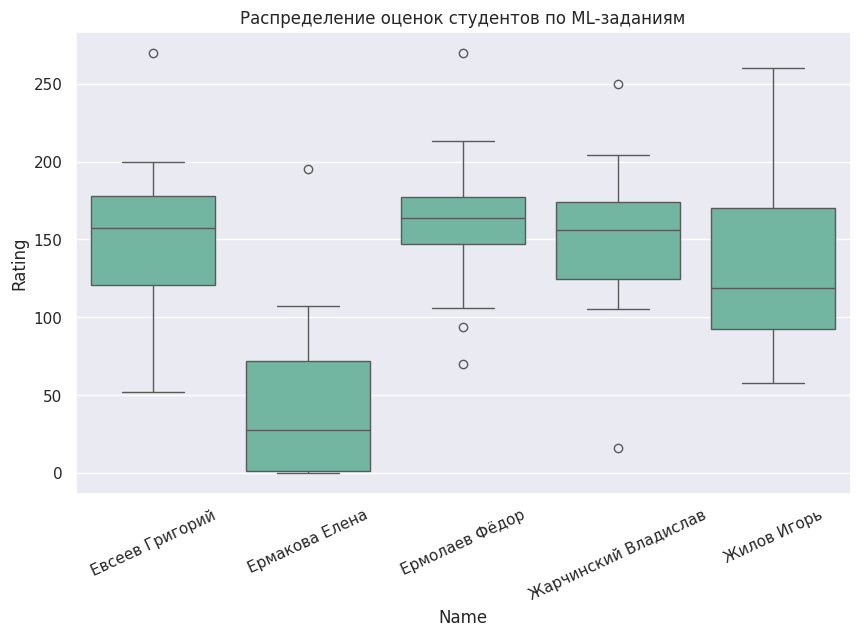

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Name", y="Rating", data=df)
plt.xticks(rotation=25)
plt.title("Распределение оценок студентов по ML-заданиям")
plt.show()

Теперь методы дисперсионного анализа

In [5]:
formula = "Rating ~ Name + Task "

model = ols(formula, data=df).fit()

aov_table = sm.stats.anova_lm(model)

aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Name,4.0,125748.478571,31437.119643,24.649381,1.772706e-11
Task,13.0,128872.642857,9913.280220,7.772857,2.930526e-08
Residual,52.0,66319.321429,1275.371566,NaN,NaN


Name -> PR=1.772706e-11, значит, есть разница между людьми в успеваемости

---

### Задача 2.

Используя теорему о разложении гауссовского вектора получите $F$-критерий однофакторного дисперсионного анализа для случая независимых выборок.

Достаточно доказать следующее распределени статистики (всего $N$ человек и $k$ групп):

$$F(X) = \frac{V_{out}/(k-1)}{V_{in}/(N-k)} \sim_{d_0} F_{k-1, N-k}$$

При $H_0$ имеем

$$X \sim N(0, \sigma^2 I_n) \qquad (*)$$

В силу независимостей это напрямую будет следовать из того, что $V_i$ распределены как соответствующие хи-квадраты:

$$V_{in} = \sum_{j=1}^{k}\sum_{i=1}^{n_j}(X_{ij}-X_{\bullet j})^2 \sim \sigma^2 \chi^2_{n-k}$$
$$V_{out} = \sum_{j=1}^{k}n_j(X_{\bullet j}-X_{\bullet \bullet})^2 \sim \sigma^2 \chi^2_{k-1}$$

Определим

$$L_{in} = \{X\in \mathbb R^N \mid \forall j : X_{\bullet j} = 0\}$$

$$L_{group} = \{X\in \mathbb R^N \mid \forall j ~ \exists c_j : X_{i j} = c_j ~ \forall i\}$$

$$L_{out} = \{X\in L_{group} \mid \sum_{j=1}^k n_j c_j = 0\}$$

Найдем размерности и докажем ортогональности.

1) $L_{in}$ имеет размерность $N - k$, потому что в каждой группе требуется равенство одной (невырожденной) линейной композиции кординат нулю - то есть для полной независимости недостаточно по 1 вектору из каждой группы чтобы получить произвольный набор координат (или просто - невырожденное уравнение в $\mathbb R^n$ задает $n-1$-мерную гиперплоскость)
2) $L_{group}$ имеет размерность $k$ - на каждую группу требуется вектор из единиц в группе
3) $L_{out}$ имеет размерность на 1 меньшую, чем $L_{group}$, то есть $k-1$, из-за линейной композиции (как в пункте 1)
4) $L_{in}$ ортогональна $L_{group}$, скалярные произведения имеют вид (суммирование по $i, j$)
$$X^{in}_{ij} X^{out}_{ij} = X^{in}_{ij} c_j = n_j X_{\bullet j} c_j = 0 \cdot c_j = 0$$

Отсюда сразу следует (из соображений размерностей), что $\mathbb R^N = L_{group} \oplus L_{out}$, этим я буду пользоваться в поиске проекции

6) $L_{out}$ ортогональна $L_{in}$ как подпространство $L_{group}$

Теперь покажем, как $V_i$ получается через соотвествующую проекцию $X$ на $L_i$

Проецируем $X$ на $L_{group}$. Это задача МНК минимизации константой в каждой группе - проекция есть вектор из соответсвующих средних $X_{\bullet j}$ (в нужных количествах). Проекция же $X$ на $L_{in}$ будет равна $X - proj_{L_{group}}X$, то есть из $X_{ij}$ вычитается среднее по группе $X_{\bullet j}$: $X_{ij} - X_{\bullet j}$ [получили ровно то, что лежит в сумме $V_{in}$!]. По теореме о разложении гауссовского вектора и учитывая (*) - получаем, что среднее будет ноль, поэтому компонента на $L_{in}$ **дает требуемое распределение $V_{in}$** (т.к. вычитаем нулевое матожидание из остатков $X_{ij} - X_{\bullet j}$)

Похожей идеем получим проекцию на $L_{out}$. Заметим, что $L_{out} \oplus Lin\{(1, 1, \ldots, 1)\} = L_{group}$ - ведь как раз не хватает вектора из единиц, причем опять $L_{out}$ ортогонально $Lin\{(1, 1, \ldots, 1)\}$, потому что скалярное произведение будет равно нулю (константа (вектор из второго пространства), умноженная на сумму компонент из $L_{out}$ (равная нулю), даст ноль)



Проекция $X$ на $Lin\{(1, 1, \ldots, 1)\}$ есть среднее $X_{\bullet \bullet}$ - это опять задача МНК минимизации, но уже по всем компонентам. Проекцию на $L_{out}$ получаем как $proj_{L_{group}} X - proj_{Lin\{(1, 1, \ldots, 1)\}} X = X_{\bullet j} - X_{\bullet \bullet}$ [получили ровно то, что лежит в сумме $V_{out}$!]. Кроме того, $Lin\{(1, 1, \ldots, 1)\}$ ортогональна $L_{out}$ как подпространство $L_{group}$

Так как в группе $j$ у нас $n_j$ слагаемых, то в $V_{out}$ вторая сумма свернется в домножение на $n_j$. По теореме о разложении гауссовского вектора (тут важна доказанная выше ортогональность) **получаем требуемое распределение $V_{out}$**

---

### Задача 3.

На занятии разобраны два способа проведения post-hoc анализа для сравнения средних нескольких независимых выборок &mdash; LSD Фишера и HSD Тьюки. 

Какое количество попарных сравнений они производят для $k$ выборок? В чем заявленное преимущество HSD Тьюки?

По $C_k^2 = \frac{k - 1}{2}$ сравнений ($k$ - число групп), заявленное преимущество $HSD$ Тьюки позволяет избежать МПГ

Опишите процедуру валидации подобно АА-тесту метода HDS Тьюки для $k=4$ выборок одного размера $n$. Какую величину будете оценивать?

Много раз
1) Генерируем $k$ одинаковых групп
2) Считаем HDS Тьюки
3) Запоминаем число отвержений

Далее оцениваем FWER 

Реализуйте эту процедуру 
* для нескольких распределений,
* для нескольких значений $n$.

In [6]:
def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(
        n_rejects, n_iter, method="wilson"
    )

    return prob_reject, left_bound, right_bound


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(7, 2),
    title=None,
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)

    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теор вероятность ошибки первого рода
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(
                pvals,
                bins=np.linspace(0, 1, 21),
                alpha=0.7,
                weights=np.ones(len(pvals)) / len(pvals),
            )
            plt.title("Распределение p-value")

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color="black", lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color="red", lw=5, linestyle="--", alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound],
            [0.15] * 2,
            [-0.15] * 2,
            color="green",
            alpha=0.6,
        )
        plt.scatter(prob_reject, 0, s=300, marker="*", color="red")
        plt.xlim(
            (min(alpha, left_bound) - 1e-3, max(alpha, right_bound) + 1e-3)
        )
        plt.title(
            f"Доля отвержений = {100*prob_reject:.2f}%, "
            f"интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)"
        )
        plt.suptitle(title)
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    effects -- сетка эффектов
    powers -- оценка реальной мощности
    left_powers, right_powers -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )
    plt.legend()
    plt.xlabel("Размер эффекта")
    plt.ylabel("Мощность")
    plt.title(title)


def draw_power_3d(
    powers,
    labels=["Многовыборочный тест"],
    effects=np.meshgrid(np.linspace(0, 0.5, 11), np.linspace(0, 0.5, 11)),
    title="График мощности многовыборочного теста",
    save_fig=False,
    filename="power",
):
    """
    Построение и отрисовка 3d-графика мощности критерия для 3 выборок.

    Аргументы:
    effects -- сетка эффектов
    powers -- массив оценок реальной мощности для всех критериев
    labels -- лейблы критериев
    title -- заголовок графика
    save_fig -- сохранять ли фигуру
    filename -- имя сохраняемой фигуры
    """

    dfs = []
    for label, power in zip(labels, powers):
        df_plot = pd.DataFrame(
            data={
                "2nd sample effect": effects[0].flatten(),
                "3rd sample effect": effects[1].flatten(),
                "power": power,
                "label": [label] * len(power),
            }
        )
        dfs.append(df_plot)

    dfs = pd.concat(dfs)
    fig = px.scatter_3d(
        dfs,
        x="2nd sample effect",
        y="3rd sample effect",
        z="power",
        color="label",
    )
    fig.show()
    if save_fig:
        pof.plot(fig, filename=f"{filename}.html", auto_open=False)


def add_effect(samples, effects, target_name="pilot", relative_effect=True):
    """
    Функция искусственного добавления эффекта в тестовые выборки

    Аргументы:
    samples -- выборки, k + 1
    effects -- добавляемые эффекты, k

    Возвращает:
    samples -- выборки с добавленным эффектом, k + 1
    """

    samples_copy = [sample.copy() for sample in samples]

    if relative_effect:
        for sample, effect in zip(samples_copy[1:], effects):
            sample[target_name] *= 1 + effect
    else:
        for sample, effect in zip(samples_copy[1:], effects):
            sample[target_name] += effect

    return samples_copy


def run_1_iteration(
    test,
    generate_samples,
    target_name,
    add_effect,
    effects_list=[0],
    relative_effect=True,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    add_effect -- функция добавления эффекта
    effects_list --  массив размеров добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным

    Возвращает: pvalue
    """

    # Генерируем выборки
    samples = generate_samples()

    pvals = []
    for effects in effects_list:
        # Добавляем эффект, если хотим оценить мощность
        samples_cp = add_effect(
            samples,
            effects,
            target_name=target_name,
            relative_effect=relative_effect,
        )
        # Применяем критерий
        pvals.append(test(samples_cp))
    return pvals


def run_experiments(
    test,
    generate_samples,
    add_effect=add_effect,
    n_iter=10_000,
    effects=[0, 0],
    relative_effect=True,
    n_jobs=4,
    alpha=0.05,
    target_name="pilot",
    draw=False,
    title=None,
    show_pvals=True,
):
    """
    Проведение серии AA-тестов на исторических данных.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    add_effect -- функция добавления эффекта
    effects -- размеры добавляемого эффекта в каждую из выборок (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """

    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test,
            generate_samples,
            target_name,
            add_effect,
            [effects],
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    pvals = np.array(pvals).flatten()
    # Подсчет числа отвержений
    n_rejects = (pvals < alpha).sum()

    # Оценка вероятности отвержения
    prob_reject, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            prob_reject,
            left_bound,
            right_bound,
            show_pvals,
            pvals,
            alpha,
            figsize,
            title,
        )

    return prob_reject, (left_bound, right_bound)


def estimate_power(
    test,
    generate_samples,
    add_effect=add_effect,
    n_iter=10_000,
    effects_list=list(
        product(np.linspace(0, 0.1, 11), np.linspace(0, 0.1, 11))
    ),
    relative_effect=True,
    n_jobs=4,
    alpha=0.05,
    target_name="pilot",
):
    """
    Проведение серии AA-тестов на исторических данных с добавением разных эффектов.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    n_iter -- количество итераций
    add_effect -- функция добавления эффекта
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """

    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test,
            generate_samples,
            target_name,
            add_effect,
            effects_list,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )

    # Подсчет числа отвержений
    n_rejects = (np.array(pvals) <= alpha).sum(axis=0)

    # Оценка мощности
    powers, left_bounds, right_bounds = estimate_reject_prob(n_rejects, n_iter)

    return powers, left_bounds, right_bounds



Генерация выборок

In [7]:
def generate_normal_samples(
    sample_sizes=(np.ones(3) * 100).astype(int), sigmas=np.ones(3)
):
    """
    Генерация нормальных выборок в любом количестве штук

    Аргументы:
    sample_sizes -- размеры каждой из выборок
    sigmas -- дисперсии каждой из выборок

    Возвращает:
    samples -- выборки
    """

    samples = []
    for sample_size, sigma in zip(sample_sizes, sigmas):
        sample = pd.DataFrame(
            sps.norm.rvs(scale=sigma, size=sample_size), columns=["pilot"]
        )
        samples.append(sample)

    return samples

def generate_uniform_samples(
    sample_sizes=(np.ones(3) * 100).astype(int), sigmas=np.ones(3)
):
    """
    Генерация равномерных выборок в любом количестве штук

    Аргументы:
    sample_sizes -- размеры каждой из выборок
    sigmas -- дисперсии каждой из выборок

    Возвращает:
    samples -- выборки
    """

    samples = []
    for sample_size, sigma in zip(sample_sizes, sigmas):
        sample = pd.DataFrame(
            sps.uniform.rvs(scale=sigma, size=sample_size), columns=["pilot"]
        )
        samples.append(sample)

    return samples

Тест

In [8]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

test = lambda samples: np.min(pairwise_tukeyhsd(
    np.concatenate([s[target_column] for s in samples]),
    np.concatenate([[i] * len(s[target_column]) for i, s in enumerate(samples)])
).pvalues)

Нормальное распределение, выборки размера 100

  0%|          | 0/1000 [00:00<?, ?it/s]

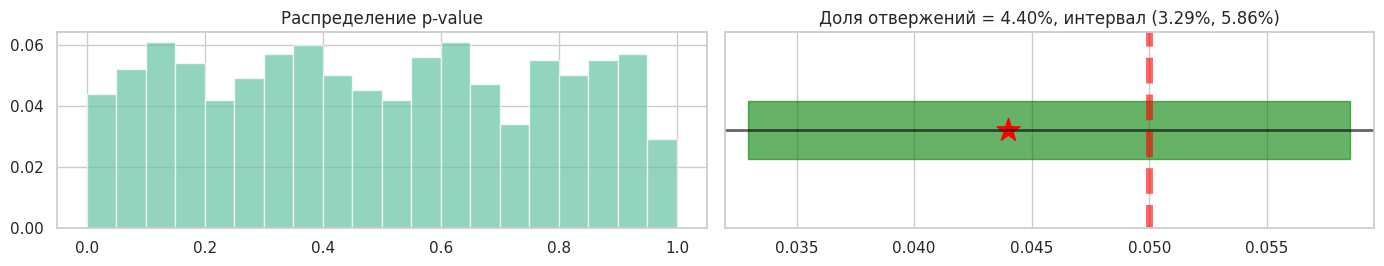

In [36]:
n_iter = 1000
alpha = 0.05
n_samples = 4
sample_sizes = (np.ones(n_samples) * 100).astype(int)
sigmas = np.ones(n_samples)
target_column = "pilot"

run_experiments(
    test=test,
    generate_samples=lambda : generate_uniform_samples(sample_sizes),
    target_name=target_column,
    n_iter=n_iter,
    alpha=alpha,
    show_pvals=True,
    draw=True,
    n_jobs=8,
);

Теперь равномерное распределение, выборки размера 100

  0%|          | 0/1000 [00:00<?, ?it/s]

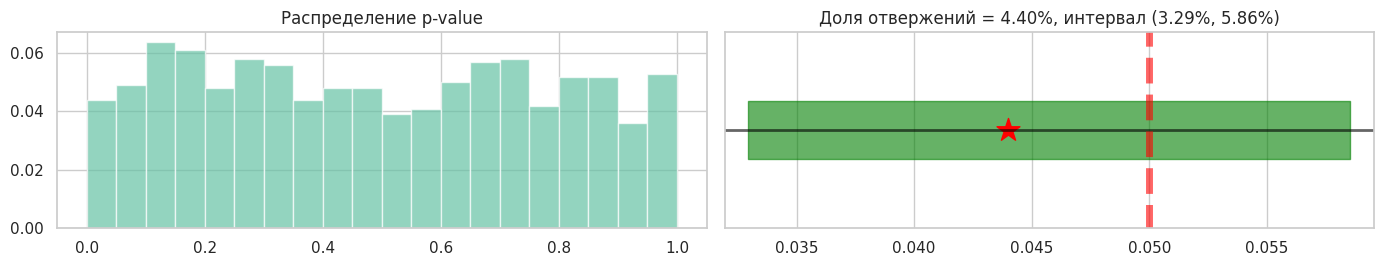

In [37]:
sample_sizes = (np.ones(n_samples) * 100).astype(int)

run_experiments(
    test=test,
    generate_samples=lambda : generate_uniform_samples(sample_sizes),
    target_name=target_column,
    n_iter=n_iter,
    alpha=alpha,
    show_pvals=True,
    draw=True,
    n_jobs=8,
);

Нормальное распределение, выборки размера 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

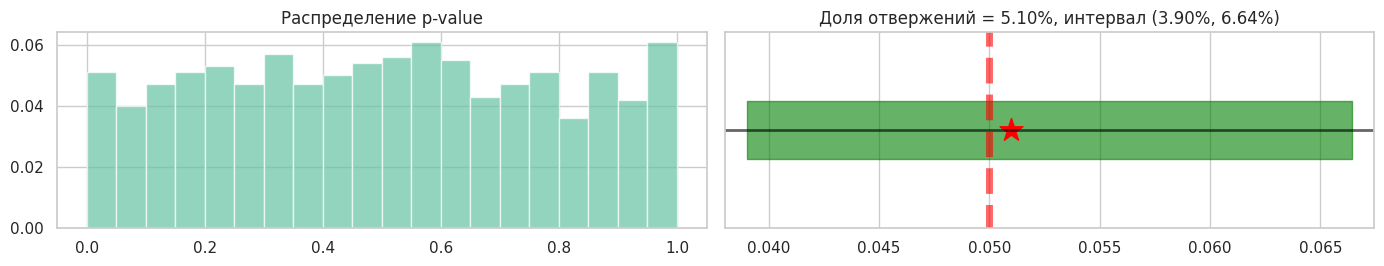

In [38]:
sample_sizes = (np.ones(n_samples) * 1000).astype(int)
run_experiments(
    test=test,
    generate_samples=lambda : generate_uniform_samples(sample_sizes),
    target_name=target_column,
    n_iter=n_iter,
    alpha=alpha,
    show_pvals=True,
    draw=True,
    n_jobs=8,
);

Равномерное распределение, выборки размера 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

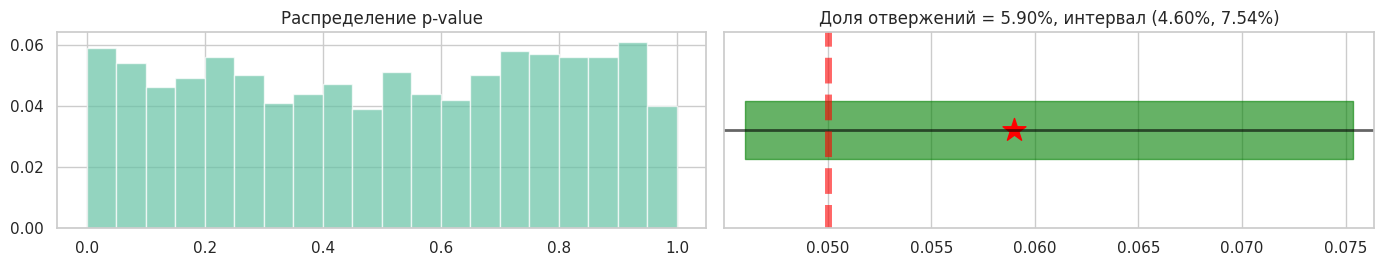

In [39]:
sample_sizes = (np.ones(n_samples) * 1000).astype(int)

run_experiments(
    test=test,
    generate_samples=lambda : generate_uniform_samples(sample_sizes),
    target_name=target_column,
    n_iter=n_iter,
    alpha=alpha,
    show_pvals=True,
    draw=True,
    n_jobs=8,
);

Все ок!

Проведите сравнение LSD Фишера и HSD Тьюки по *средней доле правильно отвергаемых гипотез* при двух альтернативах:
1. $\mu_1 = \mu_2 < \mu_3 = \mu_4$;
2. $\mu_1 < \mu_2 < \mu_2 < \mu_4$,

где $\mu_j$ &mdash; среднее по выборке $j$.

*Примечание.* В качестве реализации LSD Фишера можно использовать попарные t-test и последующее применение МПГ.

Придется модифицровать и тесты и оценку мощности (заменить ее на среднюю долю правильно отвергаемых гипотез)

In [25]:
from itertools import combinations
from statsmodels.stats.multitest import multipletests

def fisher_lsd_test(samples, target_name="pilot"):
    """Возвращает словарь {(i,j): p-value} для всех пар"""
    data = [s[target_name] for s in samples]
    k = len(data)
    pairs = list(combinations(range(k), 2))

    p_values = []
    pair_indices = []
    
    for i, j in pairs:
        _, p = sps.ttest_ind(data[i], data[j])
        p_values.append(p)
        pair_indices.append((i, j))
    
    corrected_p_values = multipletests(p_values, method='holm')[1]
    
    return {pair: p for pair, p in zip(pair_indices, corrected_p_values)}

def tukey_hsd_test(samples, target_name="pilot"):
    """Возвращает словарь {(i,j): p-value} для всех пар"""
    
    data = np.concatenate([s[target_name] for s in samples])
    groups = np.concatenate([[i]*len(s[target_name]) for i, s in enumerate(samples)])
    result = pairwise_tukeyhsd(data, groups)
    
    p_values = {}
    for row in result.summary().data[1:]:
        group1, group2, _, p_value, _, _, _ = row
        p_values[(group1, group2)] = p_value
    
    return p_values

def generate_samples(alternative="alt1", n_groups=4, sample_size=100, sigma=1.0):
    """Генерация выборок для заданной альтернативы"""
    if alternative == "alt1":
        # μ1 = μ2 < μ3 = μ4
        means = [0, 0, 0.4, 0.4]
    elif alternative == "alt2":
        # μ1 < μ2 < μ3 < μ4
        means = [0, 0.3, 0.7, 1.0]
    else:
        raise ValueError("Недопустимый тип альтернативы")
        
    samples = []
    for mean in means:
        sample = pd.DataFrame(
            sps.norm.rvs(loc=mean, scale=sigma, size=sample_size), columns=["pilot"]
        )
        samples.append(sample)
    
    return samples

def get_true_pairs(alternative="alt1"):
    """Возвращает множество истинных пар для заданной альтернативы"""
    if alternative == "alt1":
        return {(0,2), (0,3), (1,2), (1,3)}
    elif alternative == "alt2":
        return set(combinations(range(4), 2))
    else:
        raise ValueError("Недопустимый тип альтернативы")

def process_iteration(args):
    """Обрабатывает одну итерацию"""
    test_func, alternative, sample_size, sigma, alpha, true_pairs = args
    samples = generate_samples(
        alternative=alternative,
        sample_size=sample_size,
        sigma=sigma
    )
    p_values = test_func(samples)
    significant_pairs = {pair for pair, p in p_values.items() if p < alpha}
    correct_rejects = significant_pairs & true_pairs
    return len(correct_rejects)/len(true_pairs) if true_pairs else 0.0

def estimate_pairwise_power(test_func, alternative="alt1", n_iter=1000, alpha=0.05, 
                          sample_size=100, sigma=1.0, n_jobs=8):
    """
    Оценивает среднюю долю правильно отвергаемых гипотез
    
    Аргументы:
    test_func -- функция теста, возвращающая словарь p-значений
    alternative -- тип альтернативы ("alt1" или "alt2")
    n_iter -- количество итераций
    alpha -- уровень значимости
    sample_size -- размер каждой выборки
    sigma -- стандартное отклонение
    
    Возвращает:
    mean_power -- средняя доля правильных отвержений
    ci -- доверительный интервал
    """
    true_pairs = get_true_pairs(alternative)
    args = (test_func, alternative, sample_size, sigma, alpha, true_pairs)
    powers = []
    
    powers = Parallel(n_jobs=n_jobs)(
        delayed(process_iteration)(args)
        for _ in tqdm(range(n_iter), leave=False)
    )
    
    mean_power = np.mean(powers)
    ci = proportion_confint(
        sum(powers)*len(true_pairs),
        n_iter*len(true_pairs),
        method="wilson"
    )
    
    return mean_power, ci

Запуск кода

In [26]:
lsd_power_alt1, lsd_ci_alt1 = estimate_pairwise_power(
    fisher_lsd_test,
    alternative="alt1"
)

hsd_power_alt1, hsd_ci_alt1 = estimate_pairwise_power(
    tukey_hsd_test,
    alternative="alt1"
)

lsd_power_alt2, lsd_ci_alt2 = estimate_pairwise_power(
    fisher_lsd_test,
    alternative="alt2"
)

hsd_power_alt2, hsd_ci_alt2 = estimate_pairwise_power(
    tukey_hsd_test,
    alternative="alt2"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Сравним результаты

In [36]:
def plot_comparison():
    labels = ['LSD alt2', 'HSD alt2', 'LSD alt1', 'HSD alt1']
    powers = [lsd_power_alt2, hsd_power_alt2, lsd_power_alt1, hsd_power_alt1]
    cis = [lsd_ci_alt2, hsd_ci_alt2, lsd_ci_alt1, hsd_ci_alt1]
    
    plt.figure(figsize=(12,6))
    for i, (power, ci) in enumerate(zip(powers, cis)):
        plt.errorbar(
            x=power,
            y=labels[i],
            xerr=[[power - ci[0]], [ci[1] - power]],
            fmt='o',
            capsize=5
        )
    plt.xlabel('Доля правильно отвергнутых гипотез')
    plt.title('Сравнение методов для разных альтернатив')
    plt.grid(True)
    plt.show()


Сравним

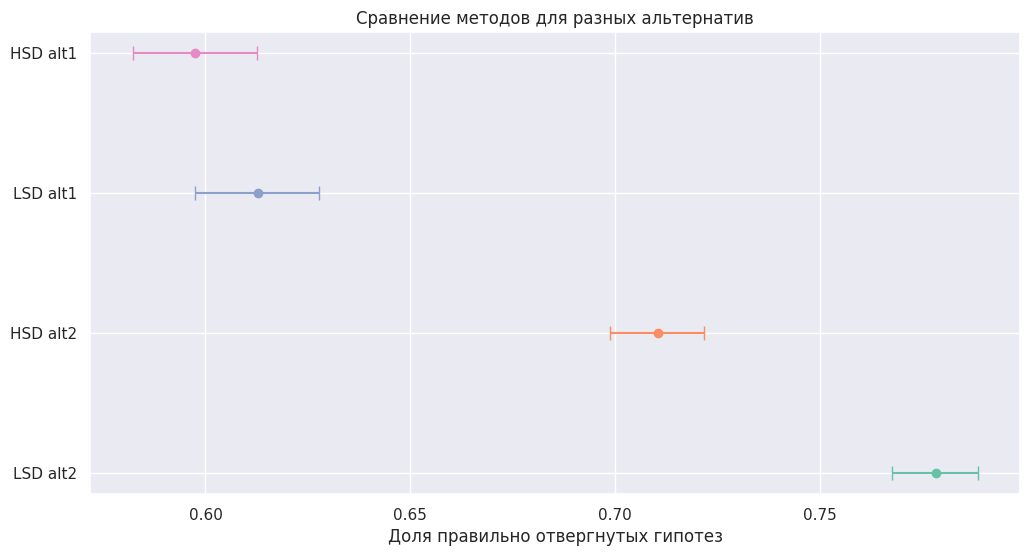

In [37]:
plot_comparison()

Сделайте выводы.

HSD Тьюки более консервативен - меньше правильно отвергнутых гипотез при обоих альтернативах; интервалы по ширине примерно одинаковые. 

---

### Задача 4.

Рассмотрим данные о внебрачных отношениях в контексте распределения времени между работой, временем, проведенным с супругом/супругой, и временем, проведенным с любовником/любовницей. Данные встроены в библиотеку `statsmodels`, почитать про них можно по <a href="http://www.statsmodels.org/stable/datasets/generated/fair.html">ссылке</a>.

Всего в данных содержатся результаты опроса 6366 человек. Опрос проводился в 1970-х, его анализ приведен в статье

    Fair, Ray. 1978. “A Theory of Extramarital Affairs,” Journal of Political Economy, February, 45-61.

Данные содержат следующие признаки:
* `rate_marriage` &mdash; оценка брака:
  * 1 = очень плохой, 
  * 2 = плохой, 
  * 3 = средний,      
  * 4 = хороший, 
  * 5 = очень хороший;
* `age` &mdash; возраст опрашиваемого;
* `yrs_married` &mdash; количество лет в браке;
* `children` &mdash; количество детей;
* `religious` &mdash; религиозность человека:
  * 1 = атеист, 
  * 2 = немного религиозный, 
  * 3 = вполне регилиозный,
  * 4 = строго религиозный;
* `educ` &mdash; уровень образования:
  * 9 = средняя школа, 
  * 12 = старшая школа, 
  * 14 = студент, 
  * 16 = выпускник вуза,
  * 17 = аспирант, 
  * 20 = выпускник аспирантуры;
* `occupation` &mdash; вид деятельности:
  * 1 = студент, 
  * 2 = сельское хозяйство, сельское хозяйство; полуквалифицированный или неквалифицированный рабочий; 
  * 3 = белый воротничок; 
  * 4 = педагог-консультант социальный работник, медсестра; художник, писатель; техник, квалифицированный рабочий, 
  * 5 = управленческий, административный, деловой, 
  * 6 = профессионал с ученой степенью;
* `occupation_husb` &mdash; вид деятельности супруга;
* `affairs` &mdash; доля времени, проведенного во внебрачных отношениях.

Изучите целевой признак. Каково его распределение, сколько там нулей? 

Далее нас будут интересовать только те люди, которые изменяли. Отфильтруйте данные.

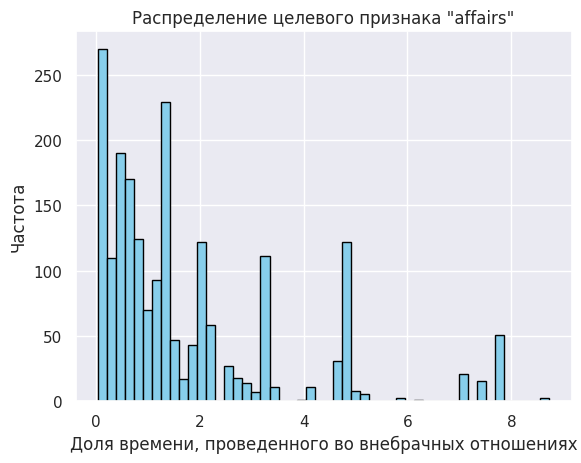

Количество людей, у которых 'affairs' = 0 (не изменяли): 4313
Общее количество людей: 6366


In [73]:
data = sm.datasets.fair.load_pandas().data

num_zeros = (data['affairs'] == 0).sum()

filtered_data = data.loc[data["affairs"] > 0, 'affairs']
filtered_data = filtered_data[filtered_data <= 10]

plt.hist(filtered_data, bins=50, edgecolor='black', color='skyblue')
plt.title('Распределение целевого признака "affairs"')
plt.xlabel('Доля времени, проведенного во внебрачных отношениях')
plt.ylabel('Частота')
plt.show()

print(f"Количество людей, у которых 'affairs' = 0 (не изменяли): {num_zeros}")
print(f"Общее количество людей: {len(data)}")

data = data.loc[data["affairs"] > 0]

Есть хвост из не очень большого числа людей, у которых сильно большая доля времени во внебрачных отношениях (>10)

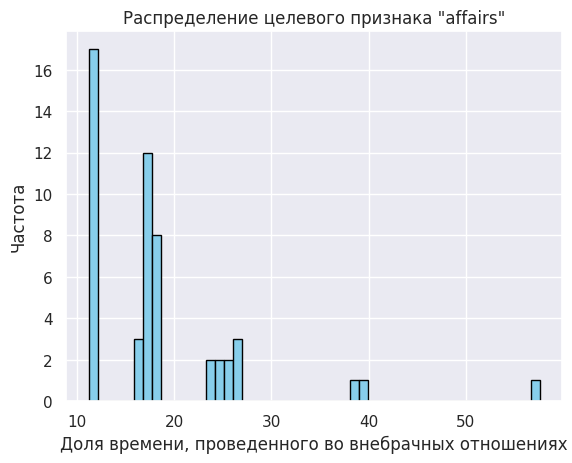

Количество людей, у которых 'affairs' > 10: 52
Общее количество тех, кто изменял: 2053


In [74]:
filtered_data = data.loc[data["affairs"] > 10, 'affairs']

plt.hist(filtered_data, bins=50, edgecolor='black', color='skyblue')
plt.title('Распределение целевого признака "affairs"')
plt.xlabel('Доля времени, проведенного во внебрачных отношениях')
plt.ylabel('Частота')
plt.show()

print(f"Количество людей, у которых 'affairs' > 10: {len(filtered_data)}")
print(f"Общее количество тех, кто изменял: {len(data)}")

Можно посмотреть на логарифм от affairs. Его распределение более близкое к нормальному (из за хвоста)

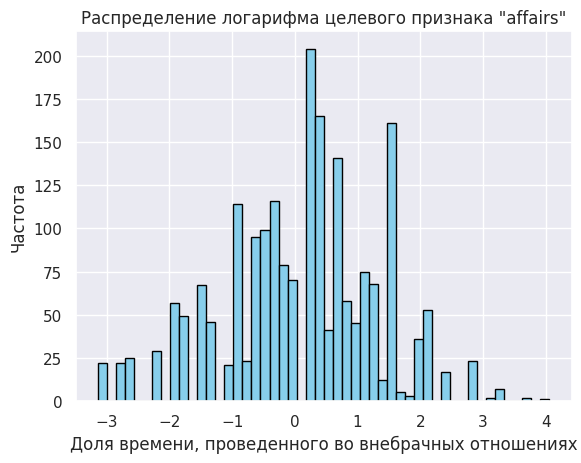

In [95]:
data['lg_affairs'] = np.log(data['affairs'])

plt.hist(data['lg_affairs'], bins=50, edgecolor='black', color='skyblue')
plt.title('Распределение логарифма целевого признака "affairs"')
plt.xlabel('Доля времени, проведенного во внебрачных отношениях')
plt.ylabel('Частота')
plt.show()

**1.** С помощью F-критерия исследуйте, по каким факторам наблюдается различие по доли времени, проведенного во внебрачных отношениях.

Не забуду про МПГ

In [96]:
vars_ = [
    'rate_marriage', 
    'age',
    'yrs_married',
    'children',
    'religious', 
    'educ', 
    'occupation', 
    'occupation_husb'
]

p_values = []
for var in vars_:
    groups = data['affairs'].groupby(by=data[var])
    samples = [np.array(group[1]) for group in groups]
    _, p_val = sps.f_oneway(*samples)
    p_values.append(p_val)

reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

results = pd.DataFrame({
    'Variable': cat_vars,
    'P-Value': p_values,
    'Adjusted P-Value': pvals_corrected,
    'Reject H0': reject
})

results

,Variable,P-Value,Adjusted P-Value,Reject H0
0,rate_marriage,1.537190e-02,6.148761e-02,False
1,age,3.569106e-56,2.498374e-55,True
2,yrs_married,7.386734e-112,5.909387e-111,True
3,children,1.831172e-47,1.098703e-46,True
4,religious,1.248360e-09,6.241798e-09,True
5,educ,1.597721e-01,3.195442e-01,False
6,occupation,2.185572e-01,3.195442e-01,False
7,occupation_husb,2.722499e-02,8.167496e-02,False


Значимое влияние на долю времени, проведенного во внебрачных отношениях, оказывают:

    возраст (age),
    количество лет в браке (yrs_married)
    дети (children),
    религиозность (religious)


**2.** По факторам, для которых нашлось статистически значимое отличие, проведите post-hoc анализ для выявления уровня факторов, для которых различается целевой признак.

Вспомогательная функция

In [141]:
def plot_matrices(var, p_matrix, diff_matrix):
    """
    Функция для визуализации матриц p-значений и разностей средних.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Матрицы для переменной {var}', fontsize=16)
    
    sns.heatmap(p_matrix.astype(float), annot=True, fmt=".4f", cmap="coolwarm", 
                cbar=True, ax=axes[0], vmin=0, vmax=0.05, mask=p_matrix.isna())
    axes[0].set_title('Матрица p-значений (с коррекцией Холма)')
    
    sns.heatmap(diff_matrix.astype(float), annot=True, fmt=".4f", cmap="coolwarm", 
                cbar=True, ax=axes[1], center=0, mask=diff_matrix.isna())
    axes[1].set_title('Матрица разностей средних')
    
    plt.show()

Итак, постарался сделать красивые таблицы, выходят очень наглядные корреляции

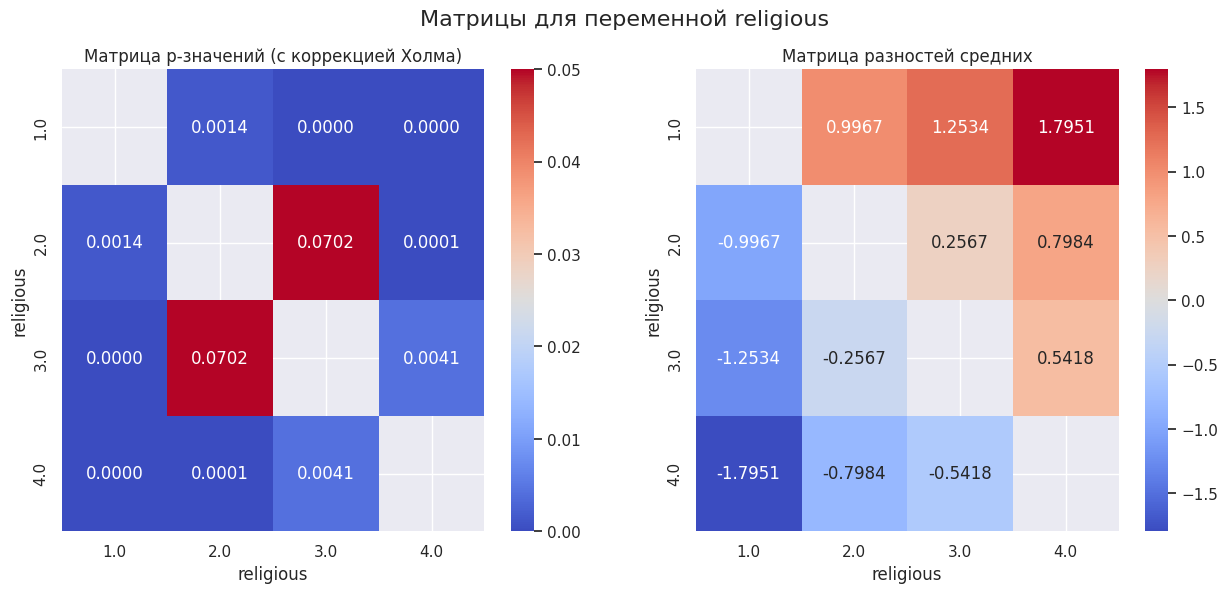

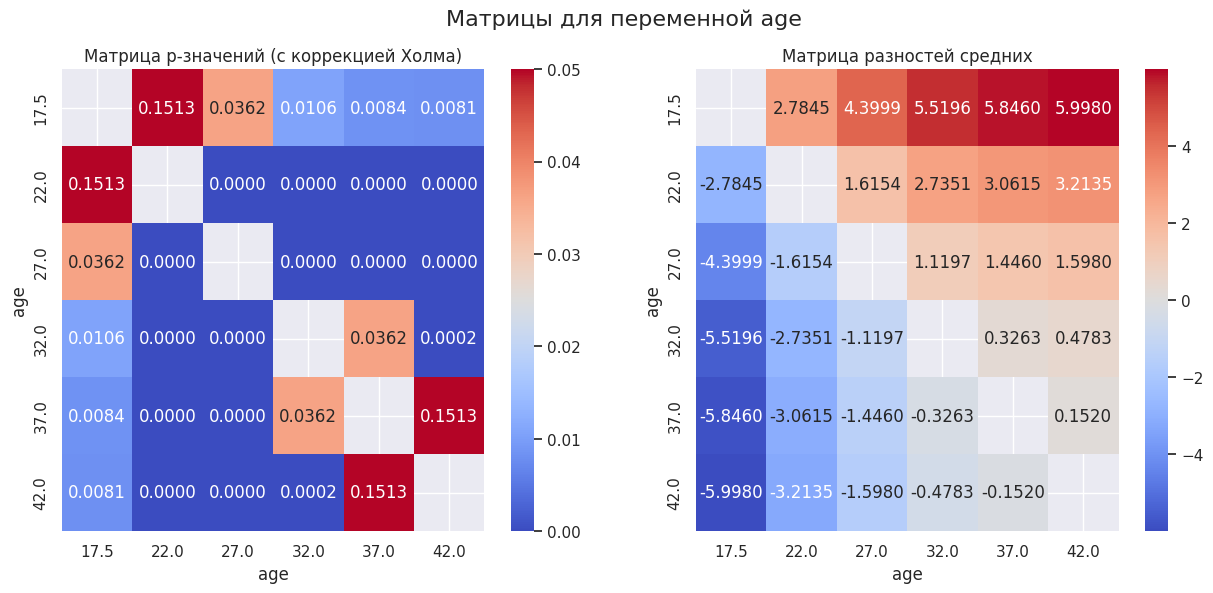

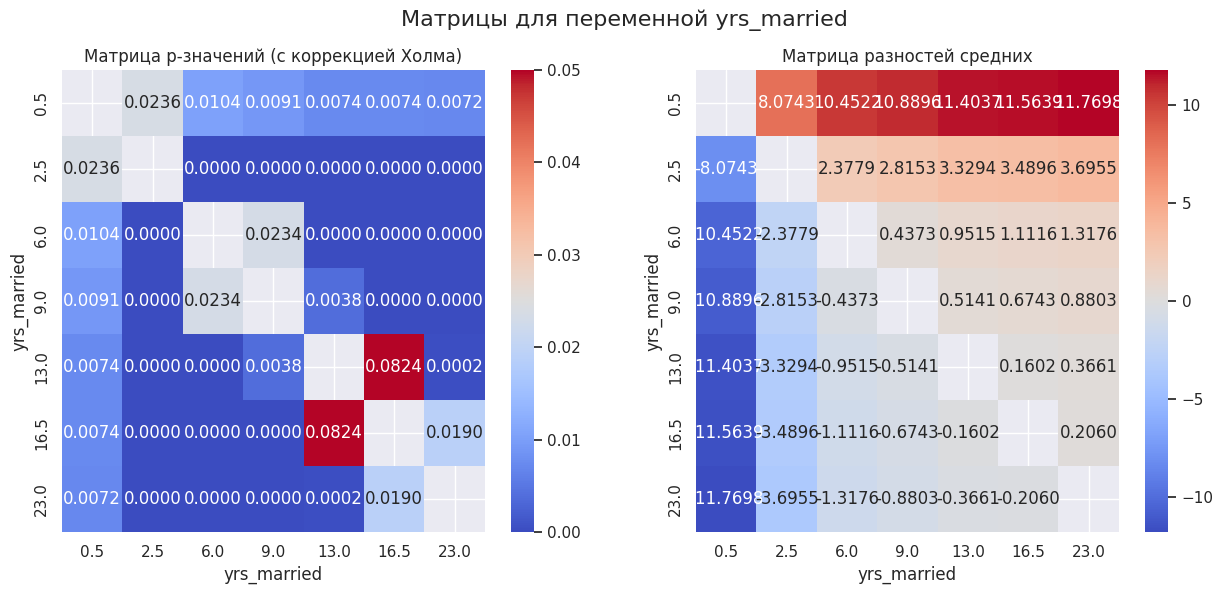

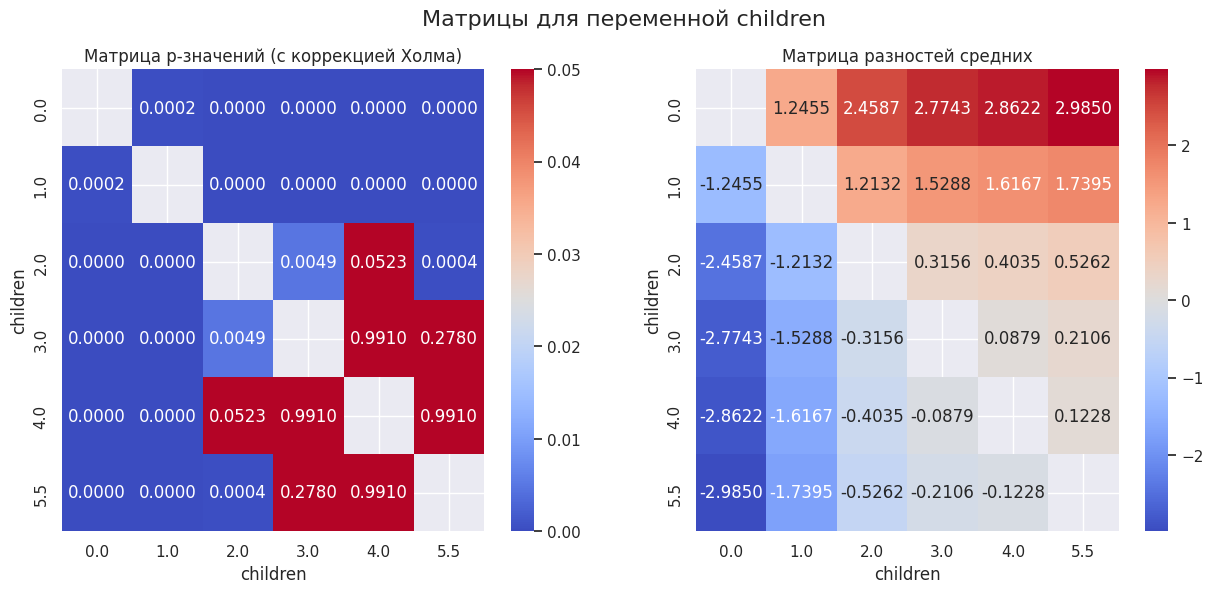

In [142]:
cat_vars = ['religious', 'age', 'yrs_married', 'children']

anova_results = []
pairwise_results = []

for var in cat_vars:
    groups = data.groupby(var)['affairs'].apply(list)
    
    unique_values = groups.index.unique()
        
    p_matrix = pd.DataFrame(index=unique_values, columns=unique_values)
    diff_matrix = pd.DataFrame(index=unique_values, columns=unique_values)
        
        
    np.fill_diagonal(p_matrix.values, np.nan)
    np.fill_diagonal(diff_matrix.values, np.nan)
        
    for group1, group2 in combinations(unique_values, 2):
        data1 = data[data[var] == group1]['affairs']
        data2 = data[data[var] == group2]['affairs']
            
        _, pval = sps.ttest_ind(data1, data2, equal_var=False)
            
        mean_diff = data1.mean() - data2.mean()
            
        p_matrix.loc[group1, group2] = pval
        p_matrix.loc[group2, group1] = pval
        diff_matrix.loc[group1, group2] = mean_diff
        diff_matrix.loc[group2, group1] = -mean_diff
        
        p_values = p_matrix.values[np.triu_indices_from(p_matrix, k=1)]
        rejected, holm_pvals, _, _ = multipletests(p_values, alpha=0.05, method='holm')
        
        p_matrix_holm = p_matrix.copy()
        idx = np.triu_indices_from(p_matrix_holm, k=1)
        p_matrix_holm.values[idx] = holm_pvals
        p_matrix_holm.values[(idx[1], idx[0])] = holm_pvals
        
    pairwise_results.append({
        'Variable': var,
        'P-Value Matrix': p_matrix_holm,
        'Mean Difference Matrix': diff_matrix
    })

for result in pairwise_results:
    var = result['Variable']
    p_matrix = result['P-Value Matrix']
    diff_matrix = result['Mean Difference Matrix']
    
    plot_matrices(var, p_matrix, diff_matrix)

1) Религиозность: чем более религиозный человек, тем меньше он проводит времени со внебрачным партнером. При этом 1 и 4 группы религиозности значимо различаются с остальными группами

2) Моложе или прожившие меньше в браке -> проводят больше времени со внебрачным партнером. Значимость почти по всем возрастам

3) Меньше детей -> проводят больше времени со внебрачным партнером. Значимость на 0-1-2 детях


**3.** Изучите совместное влияние факторов "количество лет в браке" и "количество детей" с помощью двухфактороного дисперсионного анализа. Оказывают ли какие-то уровни фактора совместное влияние?

In [149]:
model = ols('affairs ~ C(yrs_married) + C(children) + C(yrs_married):C(children)', data=data).fit(cov_type='HC3')

anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(yrs_married),2.110889e+02,6.0,3.849691e+00,0.004031
C(children),3.869729e-07,5.0,8.468808e-09,1.000000
C(yrs_married):C(children),1.102796e+02,30.0,4.022402e-01,0.526006
Residual,1.847862e+04,2022.0,NaN,NaN


Совместно незначимы, PR(>F)=0.52

**4.** Ответьте на предыдущий вопрос, сняв возможную зависимость от возраста человека и его религиозности, используя их в качестве ковариат.

In [151]:
model = ols('affairs ~ C(yrs_married) + C(children) + C(yrs_married):C(children) + age + religious', data=data).fit(cov_type='HC3')

anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(yrs_married),3.925993e+02,6.0,7.194713e+00,0.000009
C(children),3.990431e-09,5.0,8.775362e-11,1.000000
C(yrs_married):C(children),6.058099e+02,30.0,2.220396e+00,0.000387
age,1.223930e-01,1.0,1.345773e-02,0.907658
religious,8.819148e+01,1.0,9.697100e+00,0.001871
Residual,1.837114e+04,2020.0,NaN,NaN


Теперь, с ковариатами, совместная значимость появилась

**5.** По результатам исследования сделайте выводы о семейной жизни.

Если мы хотим партнера, который меньше изменяет -> ищем религиозного, более взрослого, стоит завести детей